# **SIFT Algorithm:**
* **Steps:**
    1. Scale-space Extrema Detection:
        * Scale Space and Image Pyramids
        * Finding Scale Space Extrema
    2. Keypoint Localization
    3. Orientation Assignment
        * Keypoints Orientation 
        * Cleaning Up Keypoints
    4. Keypoint Descriptor

In [1]:
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
import matplotlib.pyplot as plt
from functools import cmp_to_key
import cv2
from cv2 import KeyPoint
import numpy as np

### **1. Scale-space Extrema Detection:**
#### 1. Scale Space and Image Pyramids
1. Generate the base image by doubling the size of the input image and blurring it with a Gaussian kernel.

In [5]:
# Here we read the image and apply preporocessing to it

image = cv2.imread('..\data\\box.png')
gray = cv2.cvtColor(image, cv2.COLOR_2GRAY)

#Normalize the image to have a mean of 0 and a standard deviation of 1
gray = (gray - np.mean(gray)) / np.std(gray)
gray = gray.astype(np.int8)

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_47444\834966346.py:3: SyntaxWarning: invalid escape sequence '\d'
  image = cv2.imread('..\data\\box.png')


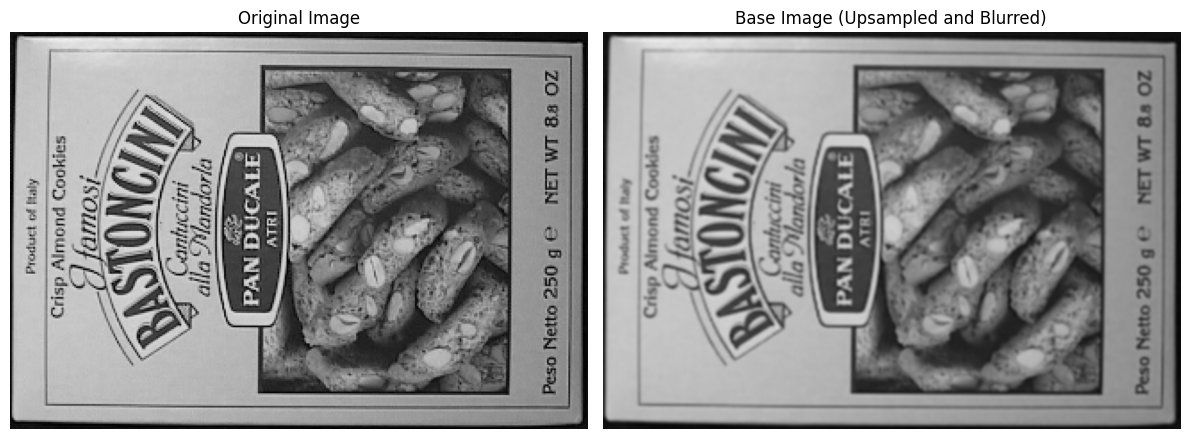

Original image shape: (223, 324, 3)
Base image shape: (446, 648, 3)


In [16]:
def generateBaseImage(image, sigma, assumed_blur):
    # Blur baseline
    image = cv2.resize(image, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return cv2.GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)


# Set parameters
sigma = 1.6
assumed_blur = 0.5
num_intervals = 3

# Generate base image
base_image = generateBaseImage(image, sigma, assumed_blur)


# Convert BGR to RGB for matplotlib display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

# Display the images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Base Image (Upsampled and Blurred)')
plt.imshow(base_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print image shapes to see the size difference
print(f"Original image shape: {image.shape}")
print(f"Base image shape: {base_image.shape}")

2. Calculate the number of actaves whitch is the number of times we can repeatedly halve an image until it becomes too small (has a side length of at least 1 pixel)
    * Mathematical Formulation:
        * If y is the minimum dimension of the image (height or width)
        * And we halve it x times
        * Then we get: y / 2^x = 1 (where 1 is the minimum size in pixels)
        * Solving for x: x = log(y) / log(2)*
    * The -1 Adjustment:
        * This subtraction of 1 ensures that the smallest image in the pyramid has a minimum dimension of at least 2 pixels
        * Actually, it ensures a minimum dimension of about 2, which `round`s to 3 pixels when implemented

In [17]:
def computeNumberOfOctaves(image_shape):
    return min(int(round(log(min(image_shape)) / log(2) - 1)), 6)# This is the number of octaves in the image whith upper limmit of 6 

# Test with different image sizes
# Test 1: A small image
small_shape = (64, 64)
print(f"For image shape {small_shape}, number of octaves = {computeNumberOfOctaves(small_shape)}")

# Test 2: A medium image
medium_shape = (256, 512)
print(f"For image shape {medium_shape}, number of octaves = {computeNumberOfOctaves(medium_shape)}")

# Test 3: A large image
large_shape = (1024, 768)
print(f"For image shape {large_shape}, number of octaves = {computeNumberOfOctaves(large_shape)}")

# Test 4: Using a real image
if image is not None:
    print(f"For Einstein image with shape {image.shape}, number of octaves = {computeNumberOfOctaves(image.shape[:2])}")
else:
    print("Could not load the image. Please check the path.")

For image shape (64, 64), number of octaves = 5
For image shape (256, 512), number of octaves = 6
For image shape (1024, 768), number of octaves = 6
For Einstein image with shape (223, 324, 3), number of octaves = 6


3. Generate the Gaussian pyramid by repeatedly applying Gaussian blur and downsampling to the base image.
    * In SIFT, we need `num_intervals + 3` images per octave because:
        * We need num_intervals + 1 images to create num_intervals DoG (Difference of Gaussian) images
        * We need 2 additional images that will be used for extrema detection at the boundaries of the octave
    * Calculating k = 2^(1/num_intervals) ensures that:
        * After num_intervals steps, the scale exactly doubles (k^num_intervals = 2)
        * This creates a consistent logarithmic sampling of the scale space
        * It allows for smooth transitions between octaves
        * The scale space is properly sampled to detect features at all scales
    * `sigma_previous = (k^(image_index-1)) * sigma`: The total blur of the previous image
    * `sigma_total = k * sigma_previous`: The total blur needed for the current image
    * `gaussian_kernels[image_index] = sqrt(sigma_total^2 - sigma_previous^2)`: The additional blur needed
    * We halve the third-to-last image, since this has the appropriate blur we want, and use this to begin the next layer.

In [18]:
def generateGaussianKernels(sigma, num_intervals):
    num_images_per_octave = num_intervals + 3
    
    
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

# Test
gaussian_kernels = generateGaussianKernels(1.6, computeNumberOfOctaves(gray.shap))
print(gaussian_kernels)

[1.6        0.81571925 0.9156139  1.02774185 1.15360122 1.29487359
 1.45344646 1.63143849 1.83122779]


In [19]:
def generateGaussianImages(image, num_octaves, gaussian_kernels):
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        # first image in octave already has the correct blur
        gaussian_images_in_octave.append(image)  
        for gaussian_kernel in gaussian_kernels[1:]:
            image = cv2.GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)
    return gaussian_images

In [20]:

def build_image_pyramid(image, num_octaves):
    """
    Builds an image pyramid by downsampling the image for each octave.
    
    Args:
        image: Input grayscale image (H x W).
        num_octaves: Number of octaves (pyramid levels).
    
    Returns:
        pyramid: List of images, each half the size of the previous.
    """
    pyramid = [image]
    for _ in range(num_octaves - 1):
        # Downsample by 2x using nearest-neighbor interpolation (for precision)
        downsampled = cv2.resize(
            pyramid[-1], 
            (int(pyramid[-1].shape[1] / 2), int(pyramid[-1].shape[0] / 2)), 
            interpolation=cv2.INTER_NEAREST
        )
        pyramid.append(downsampled)
    return pyramid

def apply_gaussian_to_octaves(pyramid, gaussian_kernels):
    """
    Applies Gaussian blur to each octave in the pyramid using the provided kernels.
    
    Args:
        pyramid: Image pyramid from `build_image_pyramid`.
        gaussian_kernels: List of σ values for blurring (e.g., [σ1, σ2, σ3]).
    
    Returns:
        gaussian_images: List of lists, where each sublist contains blurred images for an octave.
    """
    gaussian_images = []
    for octave_image in pyramid:
        octave_blurred = [octave_image]  # First image is the base (unblurred or pre-blurred)
        for sigma in gaussian_kernels[1:]:  # Skip σ0 (already in the base image)
            blurred = cv2.GaussianBlur(
                octave_blurred[-1],  # Blur the previous image in the octave
                (0, 0),  # Let OpenCV compute kernel size from σ
                sigmaX=sigma,
                sigmaY=sigma
            )
            octave_blurred.append(blurred)
        gaussian_images.append(octave_blurred)
    return gaussian_images

4. Generate the DoG images by subtracting successive pairs of these Gaussian-blurred images.

In [21]:
def generateDoGImages(gaussian_images):
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(second_image.astype(float) - first_image.astype(float)) 
        dog_images.append(dog_images_in_octave)
    return dog_images

#### Plotting Third octave of the Gaussain images and the DoG images

Number of octaves: 6
Number of octaves generated: 6


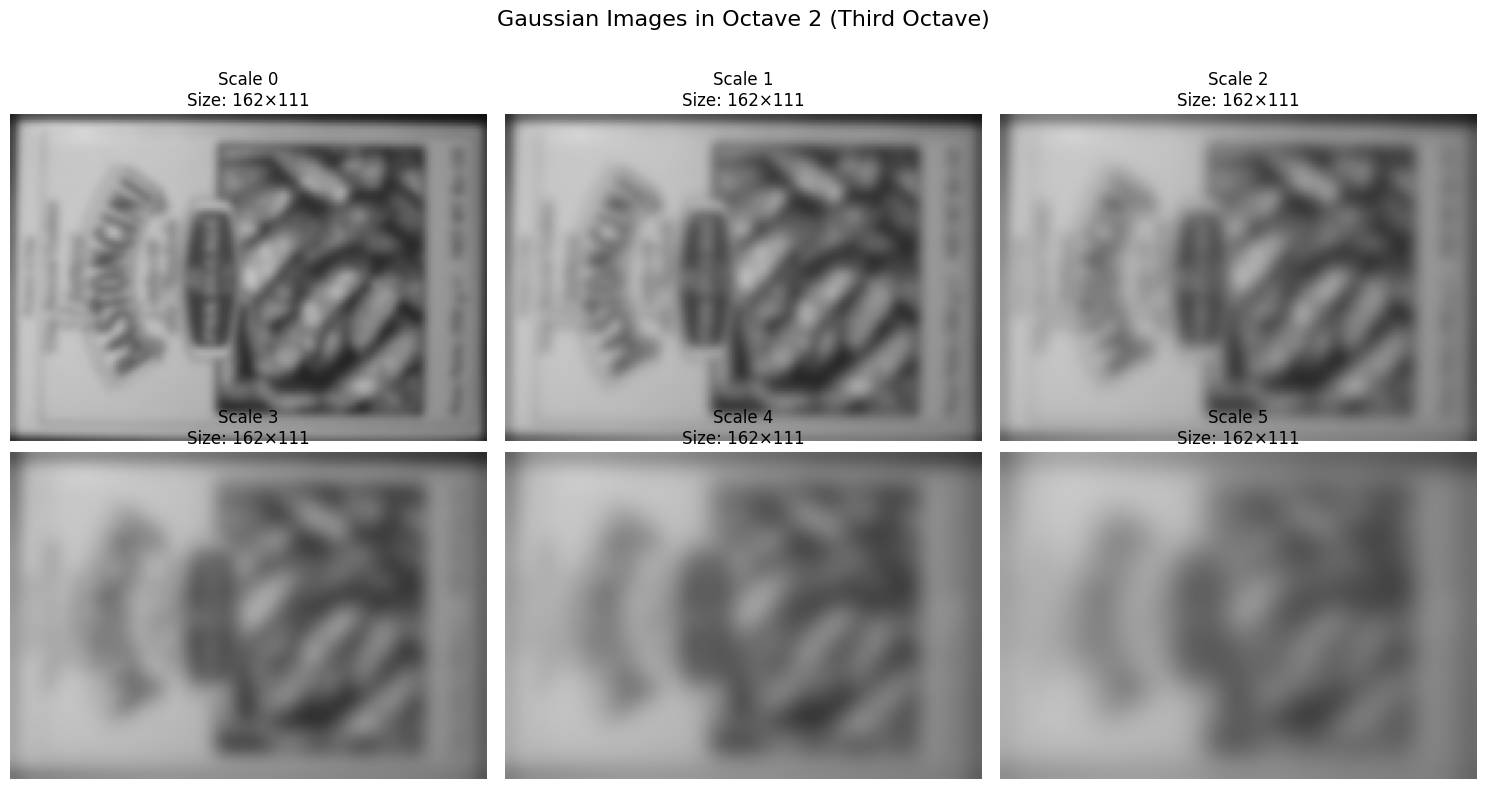

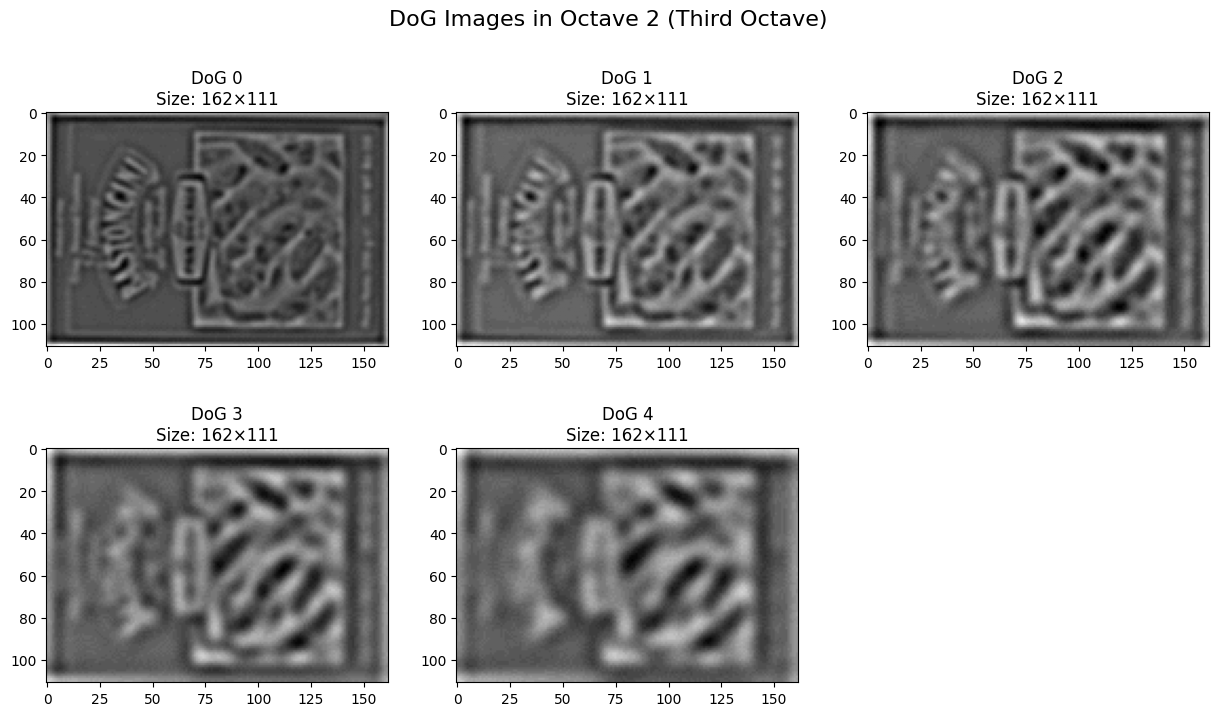

In [23]:
# Compute number of octaves
num_octaves = computeNumberOfOctaves(gray.shape)
print(f"Number of octaves: {num_octaves}")

# Generate Gaussian kernels
gaussian_kernels = generateGaussianKernels(sigma, num_intervals)

# Generate Gaussian images
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
print(f"Number of octaves generated: {len(gaussian_images)}")

# Generate DoG images
dog_images = generateDoGImages(gaussian_images)

# Check if we have at least 3 octaves
if len(gaussian_images) > 2:
    # Plot the third octave of Gaussian images
    third_octave_gaussian = gaussian_images[2]
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Gaussian Images in Octave 2 (Third Octave)', fontsize=16)
    
    for i, img in enumerate(third_octave_gaussian):
        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Scale {i}\nSize: {img.shape[1]}×{img.shape[0]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Plot the third octave of DoG images
    third_octave_dog = dog_images[2]
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('DoG Images in Octave 2 (Third Octave)', fontsize=16)
    
    for i, img in enumerate(third_octave_dog):
        plt.subplot(2, 3, i+1)
        # Normalize DoG images for better visualization
        img_normalized = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img_normalized, cmap='gray')
        plt.title(f'DoG {i}\nSize: {img.shape[1]}×{img.shape[0]}')

#### 2. Finding Scale Space Extrema:
1. In each triplet of images in each octave, we look for pixels in the middle image that are greater than or less than all of their 26 neighbors: 8 neighbors in the middle image, 9 neighbors in the image below, and 9 neighbors in the image above.
    * Function Parameters
        * first_subimage: A 3×3 patch from the previous scale (DoG image)
        * second_subimage: A 3×3 patch from the current scale, centered on the pixel being examined
        * third_subimage: A 3×3 patch from the next scale (DoG image)
        * threshold: A minimum absolute value threshold to filter out weak extrema
    * Scale s-1    Scale s      Scale s+1
    
            [1st layer]  [2nd layer]  [3rd layer]

            * * *        * * *        * * *
            * * *        * X *        * * *
            * * *        * * *        * * *

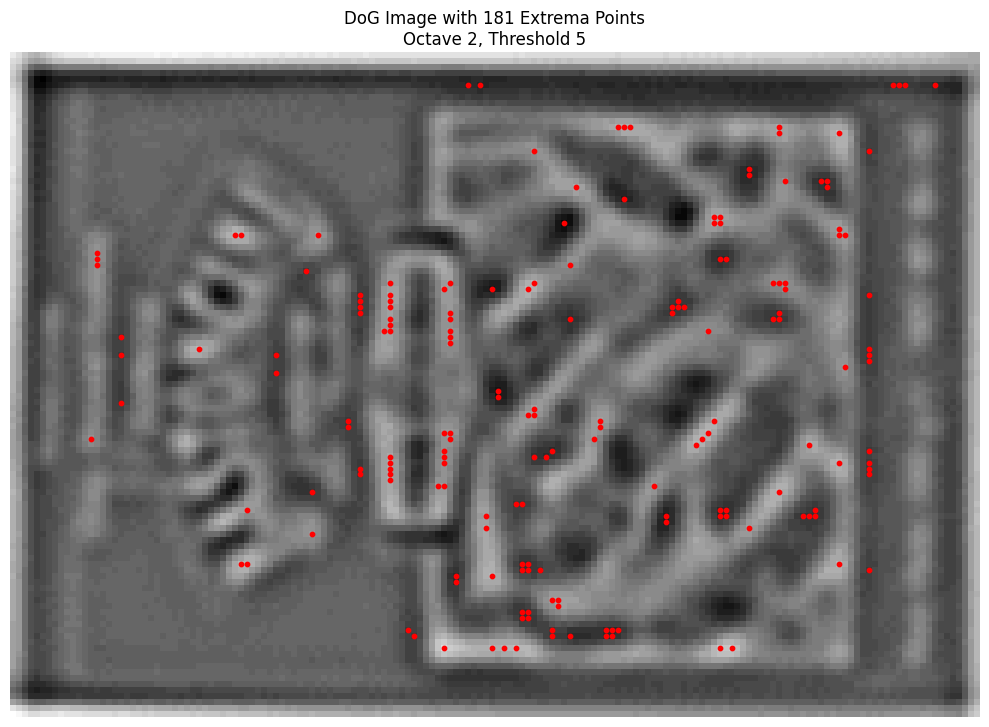

Found 181 extrema points in DoG images 1-3 of octave 2


In [48]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

# Test
# Get the DoG images from the specified octave
dog_octave = dog_images[2]

# Get the first three DoG images
first_image = dog_octave[0]
second_image = dog_octave[1]
third_image = dog_octave[2]

# Lists to store coordinates of extrema points
extrema_coords = []

# Define border width to avoid edge effects
border_width = 5

# Scan through each pixel (excluding borders)
for row in range(border_width, second_image.shape[0] - border_width):
    for col in range(border_width, second_image.shape[1] - border_width):
        # Extract 3x3 patches
        first_patch = first_image[row-1:row+2, col-1:col+2]
        second_patch = second_image[row-1:row+2, col-1:col+2]
        third_patch = third_image[row-1:row+2, col-1:col+2]
        
        # Check if it's an extremum
        if isPixelAnExtremum(first_patch, second_patch, third_patch, threshold=5):
            extrema_coords.append((row, col))

# Create a figure to display the result
plt.figure(figsize=(10, 8))

# Display the middle image with extrema points
plt.imshow(second_image, cmap='gray')

# Plot extrema points as red dots
if extrema_coords:
    extrema_coords = np.array(extrema_coords)
    plt.scatter(extrema_coords[:, 1], extrema_coords[:, 0], c='red', s=10, marker='o')

plt.title(f'DoG Image with {len(extrema_coords)} Extrema Points\nOctave {2}, Threshold {5}')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Found {len(extrema_coords)} extrema points in DoG images 1-3 of octave {2}")


### **2. Keypoints Localization:**
* **The problem:** the DoG values in the DoG images are not the actual locations and scales of the keypoints.
* **The Goal:** Accurate keypoint localization aims to refine the initial estimates of keypoint location and scale to sub-pixel and sub-scale accuracy, and to filter out unstable keypoints, leading to more reliable and accurate matching.
* **The cause of the problem:** The DoG function is already continous but the image pixels is discrete so when we generate the DoG images the pixels are not continous anymore (discrete) so the values in the DoG images are not the actual locations of the keypoints.
* **The solution:** Using Taylor expantion to approximate the DoG function at each keypoint to make it continous again and then calculate the location and the scale of the refinement keypoints.
    * Taylor series is to approximate a complex function with a polynomial, which is easier to work with. The approximation is:

        `f(x) ≈ f(a) + f'(a)(x-a) + f''(a)(x-a)²/2! + f'''(a)(x-a)³/3! + ...`
    * The Taylor series gives us a mathematical way to estimate what the continuous DoG function looks like between the discrete pixel samples.
    * a second-order Taylor series expansion around a discrete extremum point x₀ = (x₀, y₀, σ₀):
    
        `D(x) = D(x₀) + ∂D/∂x^T (x - x₀) + (1/2) (x - x₀)^T ∂²D/∂x² (x - x₀)`
        Where:
        * D(x) is the DoG function
        * x = (x, y, σ) is the 3D position
        * ∂D/∂x is the gradient (first derivatives)
        * ∂²D/∂x² is the Hessian matrix (second derivatives)
    * At an extremum, the derivative of D(x) with respect to x is zero. Taking the derivative of our Taylor expansion and setting it to zero:

        `∂D/∂x = ∂D/∂x|{x₀} + ∂²D/∂x²|{x₀} (x - x₀) = 0`
    * Solving for x: `x - x₀ = -(∂²D/∂x²|{x₀})^(-1) ∂D/∂x|{x₀}`
    * `x̂ = x - x₀`. This gives us the offset from the discrete extremum to the true extremum location.
    * The lstsq function solves the linear system Hx = g for x, where H is the Hessian and g is the gradient. This is equivalent to computing x = H⁻¹g

In [49]:
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # Need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's contrast thresholds
        # This extracts a 3×3×3 cube of pixels around the potential extremum from three consecutive DoG images
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        
        # First derivative of the DoG function of current keypoint [∂D/∂x, ∂D/∂y, ∂D/∂σ] using central difference approximation
        gradient = computeGradientAtCenterPixel(pixel_cube)

        # Second derivative of the DoG function of current keypoint (Hessian matrix) using central difference approximation
        hessian = computeHessianAtCenterPixel(pixel_cube)

        # Solving for the offset to the true extremum location.
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]


        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))

        # Make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        return None

    # Estimating the value of the DoG function at the refined extremum location (D(x₀ + x̂) = D(x₀) + (1/2) ∂D/∂x^T x̂)
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)

    # Checking if the keypoint has sufficient contrast to exclude noise
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        # Extract the 2×2 submatrix corresponding to spatial derivatives Ixx, Ixy, Iyy
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)

        # Checking for keypoints on edges to reject them using this formula ((r+1)²/r > (λ₁+λ₂)²/(λ₁λ₂)) 
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()

            # Sets the (x,y) coordinates of the keypoint in the original image space
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            
            # Sores octave information by packing multiple pieces of information into a single 32-bit integer
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            
            # The scale of the keypoint which makes sift scale invariant 
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  
            
            # Strength of the keypoint, which is the absolute value of the DoG function at the extremum used later for ranking
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    # f'(x) ≈ [f(x+h) - f(x-h)] / (2h) where (h = 1)
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    # f''(x) ≈ [f(x+h) - 2f(x) + f(x-h)] / h² where (h = 1)
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]

    # ∂²f/∂x∂y ≈ [f(x+h,y+h) - f(x+h,y-h) - f(x-h,y+h) + f(x-h,y-h)] / (4h²) where (h = 1) 
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

### **1. Orientation Assignment:**
#### 1. Keypoint Orientation:
* The goal here is to create a histogram of gradients for pixels around the keypoint’s neighborhood.
* radius_factor (default 3) determines how many "standard deviations" of the Gaussian weighting to include.
* 99.7% of the probability density of a Gaussian distribution lies inside three standard deviations, which in this case means 99.7% of the weight lies within 3 * scale pixels of the keypoint (pixels within 3* scale has the important contribution of the orientation histogram).
* **Smoothed histogram:** applies weighted circular smoothing to the histogram:
    * Each bin gets a weight of 6/16 (37.5%)
    * Adjacent bins (±1) each get a weight of 4/16 (25%)
    * Bins two steps away (±2) each get a weight of 1/16 (6.25%)
    * Total weights sum to 16/16 (100%)

In [ ]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    float_tolerance = 1e-7
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  

    # radius defines a square region of size (2×radius+1)×(2×radius+1) centered at the keypoint
    radius = int(round(radius_factor * scale))

    # From the gaussian function G(x,y) = (1/(2πσ²)) * exp(-(x² + y²)/(2σ²)), (-0.5/σ²)
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        # i and j are offsets from the keypoint's position to scan the square neighbourhood
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    
                    # In dy, The subtraction order is reversed because in images, y increases downward
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    
                    # Gaussian-weighted-gradient histogram
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        # The smoothing coefficients correspond to a 5-point Gaussian filter derived from pascal's triangle
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)

    # Finding the indicies of the local maxima by finding the indicies of the values that are greater than both the values to the left and to the right
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins      # convert to angles

            # If the angle is very close to 360°, set it to 0° (they're equivalent)
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0

            # Creating a new Keypoint with orientation
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [58]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)
    print(f"Contrast threshold: {contrast_threshold}, Calculated threshold: {threshold}")
    
    extrema_count = 0
    localization_success_count = 0
    orientation_count = 0
    
    keypoints = []
    for octave_index, dog_images_in_octave in enumerate(dog_images):
        print(f"Processing octave {octave_index}, with {len(dog_images_in_octave)} DoG images")
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            print(f"  Processing image index {image_index} in octave {octave_index}")
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        extrema_count += 1
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            localization_success_count += 1
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            orientation_count += len(keypoints_with_orientations)
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    
    print(f"Found {extrema_count} initial extrema")
    print(f"After localization: {localization_success_count} keypoints")
    print(f"After orientation assignment: {orientation_count} keypoints")
    print(f"Final keypoint count: {len(keypoints)}")
    
    return keypoints


print(findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width=5, contrast_threshold=0.04))

Contrast threshold: 0.04, Calculated threshold: 1.0
Processing octave 0, with 5 DoG images
  Processing image index 0 in octave 0


C:\Users\Compu House\AppData\Local\Temp\ipykernel_9316\4280389755.py:23: RuntimeWarning: overflow encountered in scalar subtract
  dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
C:\Users\Compu House\AppData\Local\Temp\ipykernel_9316\4280389755.py:27: RuntimeWarning: overflow encountered in scalar multiply
  gradient_magnitude = sqrt(dx * dx + dy * dy)
C:\Users\Compu House\AppData\Local\Temp\ipykernel_9316\4280389755.py:26: RuntimeWarning: overflow encountered in scalar subtract
  dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
C:\Users\Compu House\AppData\Local\Temp\ipykernel_9316\4280389755.py:27: RuntimeWarning: overflow encountered in scalar add
  gradient_magnitude = sqrt(dx * dx + dy * dy)


  Processing image index 1 in octave 0
  Processing image index 2 in octave 0
Processing octave 1, with 5 DoG images
  Processing image index 0 in octave 1
  Processing image index 1 in octave 1
  Processing image index 2 in octave 1
Processing octave 2, with 5 DoG images
  Processing image index 0 in octave 2
  Processing image index 1 in octave 2
  Processing image index 2 in octave 2
Processing octave 3, with 5 DoG images
  Processing image index 0 in octave 3
  Processing image index 1 in octave 3
  Processing image index 2 in octave 3
Processing octave 4, with 5 DoG images
  Processing image index 0 in octave 4
  Processing image index 1 in octave 4
  Processing image index 2 in octave 4
Processing octave 5, with 5 DoG images
  Processing image index 0 in octave 5
  Processing image index 1 in octave 5
  Processing image index 2 in octave 5
Processing octave 6, with 5 DoG images
  Processing image index 0 in octave 6
  Processing image index 1 in octave 6
  Processing image index 

#### 2. Cleaning Up Keypoints:
1. Sort and remove duplicates
    * Considers keypoints to be duplicates if they have identical position, size, AND orientation to handle features with multiple dominant orientations
2. Convert our keypoints from base image coordinates to input image coordinates
    * Adjust the octave information:
        * (keypoint.octave & ~255) preserves the higher bits of the octave field
        * ((keypoint.octave - 1) & 255) decrements the octave index in the lower 8 bits
        * The | (bitwise OR) combines these values

In [ ]:
def compareKeypoints(keypoint1, keypoint2):
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        # Considers keypoints to be duplicates if they have identical position, size, AND orientation 
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

def convertKeypointsToInputImageSize(keypoints):
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

#### Plotting The Localized Keypoints

Processing image: E:\Rawan\Projects\Computer Vision\Task3PrespicteFeatureExtraction&Matching\Task3-Perceptive-Features-Extraction-Matching\data\box.png, shape: (223, 324)
Number of octaves: 8
Contrast threshold: 0.04, Calculated threshold: 1.0
Processing octave 0, with 5 DoG images
  Processing image index 0 in octave 0
  Processing image index 1 in octave 0
  Processing image index 2 in octave 0
Processing octave 1, with 5 DoG images
  Processing image index 0 in octave 1
  Processing image index 1 in octave 1
  Processing image index 2 in octave 1
Processing octave 2, with 5 DoG images
  Processing image index 0 in octave 2
  Processing image index 1 in octave 2
  Processing image index 2 in octave 2
Processing octave 3, with 5 DoG images
  Processing image index 0 in octave 3
  Processing image index 1 in octave 3
  Processing image index 2 in octave 3
Processing octave 4, with 5 DoG images
  Processing image index 0 in octave 4
  Processing image index 1 in octave 4
  Processing im

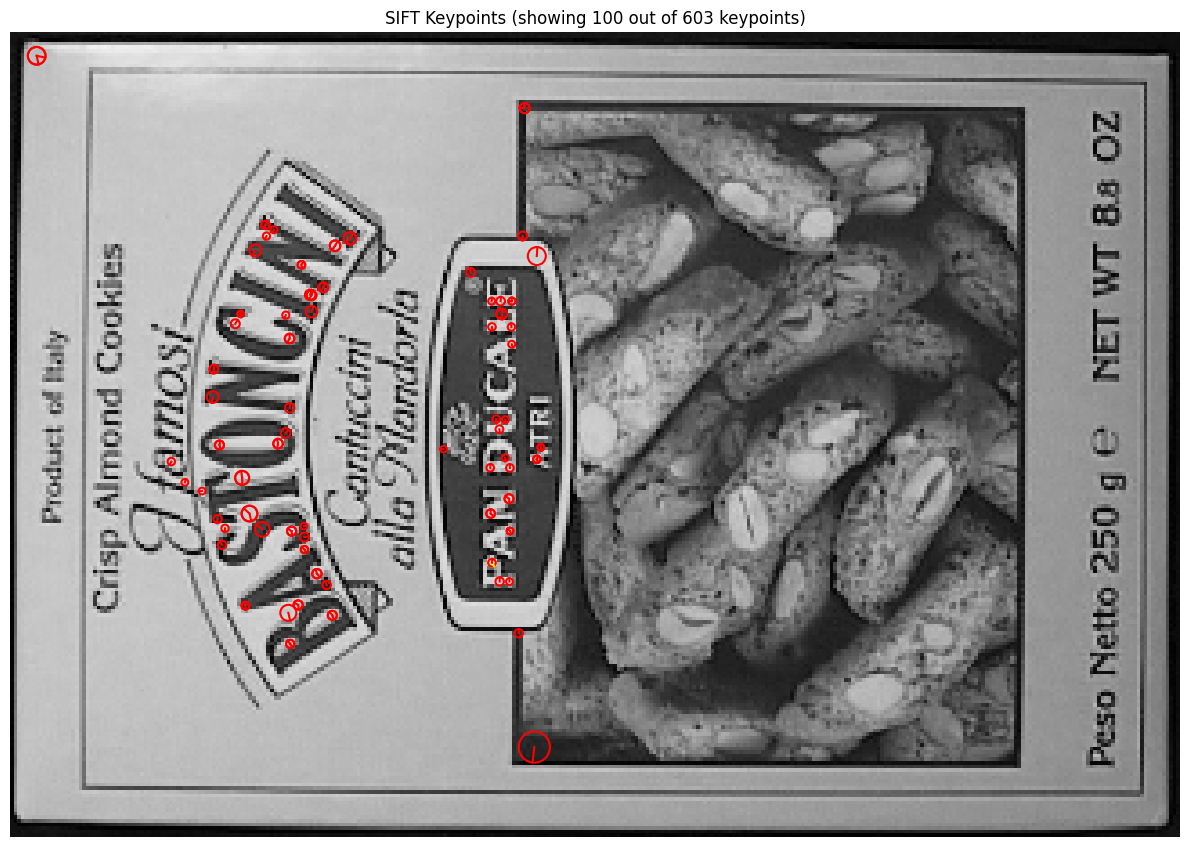

In [ ]:
from matplotlib.patches import Circle

def visualize_keypoints_and_print_details(image_path, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5, max_keypoints=None):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Could not load image from {image_path}")
        return
    
    print(f"Processing image: {image_path}, shape: {image.shape}")
    
    # Convert image to float32 to avoid overflow issues
    image = image.astype(np.float32)
    
    # Generate base image
    base_image = generateBaseImage(image, sigma, assumed_blur)
    
    # Compute number of octaves
    num_octaves = computeNumberOfOctaves(base_image.shape)
    print(f"Number of octaves: {num_octaves}")
    
    # Generate Gaussian kernels
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    
    # Generate Gaussian images
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    
    # Generate DoG images
    dog_images = generateDoGImages(gaussian_images)
    
    # Find keypoints
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    
    if keypoints is None or len(keypoints) == 0:
        print("No keypoints were detected.")
        return
    
    print(f"Found {len(keypoints)} keypoints")
    
    # Convert image back to uint8 for visualization
    display_image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Display the image
    plt.imshow(display_image)
    
    # Create a plot with circles for keypoints
    ax = plt.gca()
    
    # Sort keypoints by response (strongest first)
    sorted_keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)
    
    # Determine how many keypoints to display
    if max_keypoints is None:
        # Display all keypoints
        keypoints_to_display = sorted_keypoints
    else:
        # Display only the specified number of keypoints
        keypoints_to_display = sorted_keypoints[:max_keypoints]
    
    print(f"Displaying {len(keypoints_to_display)} keypoints")
    
    # Plot each keypoint
    for i, kp in enumerate(keypoints_to_display):
        # Get keypoint coordinates
        x, y = kp.pt
        # Get keypoint size (scale)
        size = kp.size
        
        # Use a different color for the strongest keypoint
        color = 'yellow' if i == 0 else 'red'
        
        # Draw circle at keypoint location with radius proportional to keypoint size
        circle = Circle((x, y), size/2, fill=False, edgecolor=color, linewidth=1.5)
        ax.add_patch(circle)
        
        # Draw a line indicating orientation if available
        if hasattr(kp, 'angle') and kp.angle is not None:
            angle_rad = np.deg2rad(kp.angle)
            dx = np.cos(angle_rad) * size/2
            dy = np.sin(angle_rad) * size/2
            plt.plot([x, x+dx], [y, y+dy], color=color, linewidth=1.5)
    
    plt.title(f'SIFT Keypoints (showing all {len(keypoints_to_display)} keypoints)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run the function with the box.png image and display all keypoints
visualize_keypoints_and_print_details(
    'E:\\Rawan\\Projects\\Computer Vision\\Task3PrespicteFeatureExtraction&Matching\\Task3-Perceptive-Features-Extraction-Matching\\data\\box.png',
    max_keypoints=None  # Set to None to display all keypoints
)

#### Test with openCV SIFT:

OpenCV SIFT detected 604 keypoints


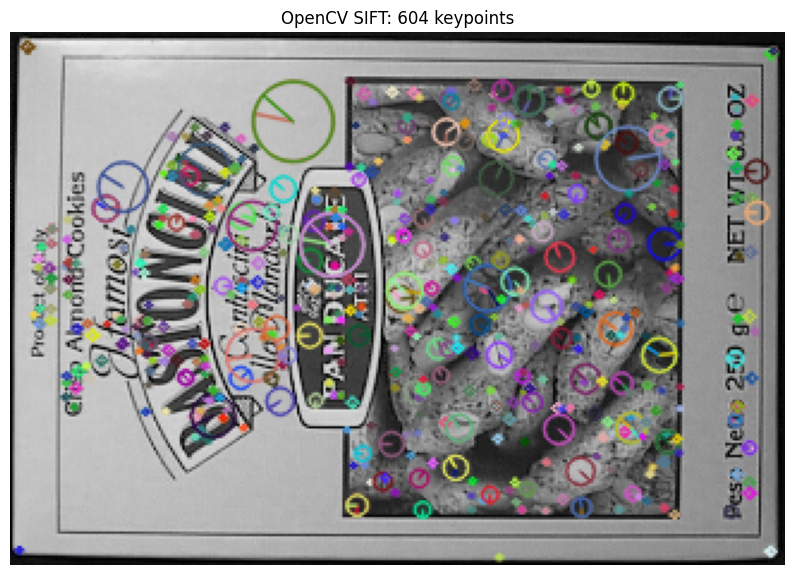

In [ ]:
def test_with_opencv_sift(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Could not load image from {image_path}")
        return
    
    # Create OpenCV SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints
    keypoints = sift.detect(image, None)
    
    print(f"OpenCV SIFT detected {len(keypoints)} keypoints")
    
    # Draw keypoints
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f'OpenCV SIFT: {len(keypoints)} keypoints')
    plt.axis('off')
    plt.show()

# Test with OpenCV's SIFT
test_with_opencv_sift('E:\\Rawan\\Projects\\Computer Vision\\Task3PrespicteFeatureExtraction&Matching\\Task3-Perceptive-Features-Extraction-Matching\\data\\box.png')


## **References:** 
* [Link to the sift paper](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)
* [Link to the article part 1](https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5) 
* [Link to the article part 2](https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-2-c4350274be2b)